<a href="https://colab.research.google.com/github/abhipise2704/Machine_learning-/blob/master/Truncated_SVD_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DonorsChoose
## Assignment 11: TruncatedSVD on Donors Choose dataset 
### abhipise2704@gmail.com_11

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter

# 1 Data Preprocessing 

## 1.1 Reading Data

In [0]:
#project_data = pd.read_csv('train_data.csv')
#resource_data = pd.read_csv('resources.csv')

In [0]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [0]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [0]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 19)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'price' 'quantity']


In [0]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1,725.05,4
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1,213.03,8


In [0]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


## 1.2 preprocessing of `project_subject_categories`

In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.4 preprocessing of `Project_Grade_Category`

In [0]:
#https://www.kaggle.com/naveennagari/donorschoose-eda-and-tsne/notebook

cleaned_Grades=[]
for grade in tqdm(project_data['project_grade_category'].values):
    grade = grade.replace(' ', '_')
    grade = grade.replace('-', '_')
    cleaned_Grades.append(grade)
project_data['cleaned_Grades']=cleaned_Grades


project_data.drop(['project_grade_category'], axis=1, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [00:00<00:00, 471195.09it/s]


In [0]:
project_data['cleaned_Grades'][:5]

55660    Grades_PreK_2
76127       Grades_3_5
51140    Grades_PreK_2
473      Grades_PreK_2
41558       Grades_3_5
Name: cleaned_Grades, dtype: object

## 1.4 preprocessing of `School State`

In [0]:
from collections import Counter
my_counter = Counter()
for word in project_data['school_state'].values:
    my_counter.update(word.split())
    
state__ = dict(my_counter)
sorted_state_dict = dict(sorted(state__.items(), key=lambda kv: kv[1]))

## 1.5 preprocessing of `Teacher Prefix`

In [0]:
#https://towardsdatascience.com/5-methods-to-remove-the-from-your-data-in-python-and-the-fastest-one-281489382455

project_data['teacher_prefix_clean']=project_data.teacher_prefix.str.replace('.','')


#https://stackoverflow.com/questions/23158447/convert-float-to-string-in-pandas

project_data['teacher_prefix_clean'] = project_data['teacher_prefix_clean'].astype(str)

from collections import Counter
my_counter = Counter()
for word in project_data['teacher_prefix_clean'].values:
    my_counter.update(word.split())
    

teacher_dict = dict(my_counter)
sorted_teacher_dict = dict(sorted(teacher_dict.items(), key=lambda kv: kv[1]))


project_data.drop(['teacher_prefix'], axis=1, inplace=True)

## 1.6 Text preprocessing of `essay`

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,school_state,Date,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_categories,clean_subcategories,cleaned_Grades,teacher_prefix_clean,essay
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,CA,2016-04-27 00:27:36,Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1,725.05,4,Math_Science,AppliedSciences Health_LifeScience,Grades_PreK_2,Mrs,I have been fortunate enough to use the Fairy ...
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,UT,2016-04-27 00:31:25,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1,213.03,8,SpecialNeeds,SpecialNeeds,Grades_3_5,Ms,Imagine being 8-9 years old. You're in your th...


In [0]:
#### Using Pretrained Models: TFIDF weighted W2V

In [0]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[15000])
print("="*50)
print(project_data['essay'].values[40000])
print("="*50)

I have been fortunate enough to use the Fairy Tale STEM kits in my classroom as well as the STEM journals, which my students really enjoyed.  I would love to implement more of the Lakeshore STEM kits in my classroom for the next school year as they provide excellent and engaging STEM lessons.My students come from a variety of backgrounds, including language and socioeconomic status.  Many of them don't have a lot of experience in science and engineering and these kits give me the materials to provide these exciting opportunities for my students.Each month I try to do several science or STEM/STEAM projects.  I would use the kits and robot to help guide my science instruction in engaging and meaningful ways.  I can adapt the kits to my current language arts pacing guide where we already teach some of the material in the kits like tall tales (Paul Bunyan) or Johnny Appleseed.  The following units will be taught in the next school year where I will implement these kits: magnets, motion, si

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

\"A person is a person, no matter how small.\" (Dr.Seuss) I teach the smallest students with the biggest enthusiasm for learning. My students learn in many different ways using all of our senses and multiple intelligences. I use a wide range of techniques to help all my students succeed. \r\nStudents in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures, including Native Americans.\r\nOur school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom. Kindergarteners in my class love to work with hands-on materials and have many different opportunities to practice a skill before it is mastered. Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum.Montana is the perfect place to learn about agriculture and nutrition. My students love to role play in our pretend kitchen in the ear

In [0]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

 A person is a person, no matter how small.  (Dr.Seuss) I teach the smallest students with the biggest enthusiasm for learning. My students learn in many different ways using all of our senses and multiple intelligences. I use a wide range of techniques to help all my students succeed.   Students in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures, including Native Americans.  Our school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom. Kindergarteners in my class love to work with hands-on materials and have many different opportunities to practice a skill before it is mastered. Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum.Montana is the perfect place to learn about agriculture and nutrition. My students love to role play in our pretend kitchen in the early chi

In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

 A person is a person no matter how small Dr Seuss I teach the smallest students with the biggest enthusiasm for learning My students learn in many different ways using all of our senses and multiple intelligences I use a wide range of techniques to help all my students succeed Students in my class come from a variety of different backgrounds which makes for wonderful sharing of experiences and cultures including Native Americans Our school is a caring community of successful learners which can be seen through collaborative student project based learning in and out of the classroom Kindergarteners in my class love to work with hands on materials and have many different opportunities to practice a skill before it is mastered Having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum Montana is the perfect place to learn about agriculture and nutrition My students love to role play in our pretend kitchen in the early childhood classroom

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [02:17<00:00, 794.55it/s]


In [0]:
# after preprocesing
project_data['preprocessed_essays']=preprocessed_essays

In [0]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,school_state,Date,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,...,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_categories,clean_subcategories,cleaned_Grades,teacher_prefix_clean,essay,preprocessed_essays
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,CA,2016-04-27 00:27:36,Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,...,53,1,725.05,4,Math_Science,AppliedSciences Health_LifeScience,Grades_PreK_2,Mrs,I have been fortunate enough to use the Fairy ...,fortunate enough use fairy tale stem kits clas...
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,UT,2016-04-27 00:31:25,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,...,4,1,213.03,8,SpecialNeeds,SpecialNeeds,Grades_3_5,Ms,Imagine being 8-9 years old. You're in your th...,imagine 8 9 years old third grade classroom se...


In [0]:
project_data['preprocessed_essays'][:10]


55660    fortunate enough use fairy tale stem kits clas...
76127    imagine 8 9 years old third grade classroom se...
51140    class 24 students comes diverse learners stude...
473      recently read article giving students choice l...
41558    students crave challenge eat obstacles breakfa...
29891    end school year routines run course students n...
81565    sitting still overrated makes sense opera medi...
79026    not enough read book write essay connect deepl...
23374    never society rapidly changed technology invad...
86551    remember first time saw star wars wall e robot...
Name: preprocessed_essays, dtype: object

<h2><font color='black'> 1.7 Text Preprocessing of `project_title`</font></h2>

In [0]:
# similarly you can preprocess the titles also

In [0]:
project_data['project_title'][:10]

55660         Engineering STEAM into the Primary Classroom
76127                              Sensory Tools for Focus
51140       Mobile Learning with a Mobile Listening Center
473                 Flexible Seating for Flexible Learning
41558               Going Deep: The Art of Inner Thinking!
29891                   Breakout Box to Ignite Engagement!
81565    Flexible Seating: An Environment to Help Kids ...
79026                21st Century Learning with Multimedia
23374                                    iPad for Learners
86551                      Dash and Dot Robotic Duo Needed
Name: project_title, dtype: object

In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_project_title = decontracted(project_data['project_title'].values[1000])
print(sent_project_title)
print("="*50)

Empowering Students Through Art:Learning About Then and Now


In [0]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent_project_title = sent_project_title.replace('\\r', ' ')
sent_project_title = sent_project_title.replace('\\"', ' ')
sent_project_title = sent_project_title.replace('\\n', ' ')
print(sent_project_title)

Empowering Students Through Art:Learning About Then and Now


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_project_title = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent_project_title)

first graders eager learn world around come school day full enthusiasm genuinely love learning diverse class includes students variety cultural economic backgrounds Many come homes parents not afford simply not know importance books important provide environment rich literature students learn love reading want students lifelong learners reading best way used magazines past kids absolutely LOVE topics high interest children always correspond real world issues important kids learn subscription also includes online resources videos printable worksheets skill based games materials expose students rigorous interesting nonfiction text spark curiosity world around topics allow teach nonfiction text standards using interesting materials always lead engaging discussions inspire students find additional information various topics nannan


In [0]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
from tqdm import tqdm
preprocessed_project_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent_project_title = decontracted(sentance)
    sent_project_title = sent_project_title.replace('\\r', ' ')
    sent_project_title = sent_project_title.replace('\\"', ' ')
    sent_project_title = sent_project_title.replace('\\n', ' ')
    sent_project_title = re.sub('[^A-Za-z0-9]+', ' ', sent_project_title)
    # https://gist.github.com/sebleier/554280
    sent_project_title = ' '.join(e for e in sent_project_title.split() if e not in stopwords)
    preprocessed_project_title.append(sent_project_title.lower().strip())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [00:07<00:00, 15417.85it/s]


In [0]:
preprocessed_project_title[1000]

'empowering students through art learning about then now'

In [0]:
project_data['preprocessed_project_title']=preprocessed_project_title

In [0]:
project_data['preprocessed_project_title'][:10]

55660                engineering steam primary classroom
76127                                sensory tools focus
51140            mobile learning mobile listening center
473                   flexible seating flexible learning
41558                  going deep the art inner thinking
29891                     breakout box ignite engagement
81565    flexible seating an environment help kids learn
79026                   21st century learning multimedia
23374                                      ipad learners
86551                        dash dot robotic duo needed
Name: preprocessed_project_title, dtype: object

<h2><font color='black'> 1.8 Sentiment Score of Essays </font></h2>

In [0]:
#https://www.youtube.com/watch?v=qTyj2R-wcks
#https://www.kaggle.com/rohit0812/logistic-regression-on-donor-s-choose/notebook
#https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f
#https://github.com/varma1993/ML-Projects/blob/master/DonorsChoose/Logistic%20Regression/5_DonorsChoose_LR_final.ipynb
#http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

project_data['sentiment_score'] = 0
project_data['sentiment_score'] = project_data['sentiment_score'].astype(float)

sentiment_analyzer = SentimentIntensityAnalyzer()

for index in tqdm(project_data.index):
    project_data.at[index, 'sentiment_score'] = sentiment_analyzer.polarity_scores(project_data.at[index,'preprocessed_essays'])['compound']

print(project_data.head(2))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [06:51<00:00, 265.55it/s]


       Unnamed: 0       id                        teacher_id school_state  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           CA   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df           UT   

                     Date                                 project_title  \
55660 2016-04-27 00:27:36  Engineering STEAM into the Primary Classroom   
76127 2016-04-27 00:31:25                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   


<h2><font color='black'> 1.9 Number of Words in Essays </font></h2>

In [0]:
#https://stackoverflow.com/questions/54397096/how-to-do-word-count-on-pandas-dataframe

project_data['number_words_essays']=project_data['preprocessed_essays'].str.count(' ')+1

<h2><font color='black'> 1.10 Number of Words in Project Title </font></h2>

In [0]:
#https://stackoverflow.com/questions/54397096/how-to-do-word-count-on-pandas-dataframe

project_data['number_words_project_title'] = project_data['preprocessed_project_title'].str.count(' ')+1

# Assignment 11: TruncatedSVD

- <font color='red'>step 1</font> Select the top 2k words from essay text and project_title (concatinate essay text with project title and then find the top 2k words) based on their <a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html'>`idf_`</a> values 
- <font color='red'>step 2</font> Compute the co-occurance matrix with these 2k words, with window size=5 (<a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>ref</a>)
    <img src='cooc.JPG' width=300px>
- <font color='red'>step 3</font> Use <a href='http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html'>TruncatedSVD</a> on calculated co-occurance matrix and reduce its dimensions, choose the number of components (`n_components`) using <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/pca-code-example-using-non-visualization/'>elbow method</a>
 >- The shape of the matrix after TruncatedSVD will be 2000\*n, i.e. each row represents a vector form of the corresponding word. <br>
 >- Vectorize the essay text and project titles using these word vectors. (while vectorizing, do ignore all the words which are not in top 2k words)
- <font color='red'>step 4</font> Concatenate these truncatedSVD matrix, with the matrix with features
<ul>
    <li><strong>school_state</strong> : categorical data</li>
    <li><strong>clean_categories</strong> : categorical data</li>
    <li><strong>clean_subcategories</strong> : categorical data</li>
    <li><strong>project_grade_category</strong> :categorical data</li>
    <li><strong>teacher_prefix</strong> : categorical data</li>
    <li><strong>quantity</strong> : numerical data</li>
    <li><strong>teacher_number_of_previously_posted_projects</strong> : numerical data</li>
    <li><strong>price</strong> : numerical data</li>
    <li><strong>sentiment score's of each of the essay</strong> : numerical data</li>
    <li><strong>number of words in the title</strong> : numerical data</li>
    <li><strong>number of words in the combine essays</strong> : numerical data</li>
    <li><strong>word vectors calculated in</strong> <font color='red'>step 3</font> : numerical data</li>
</ul>
- <font color='red'>step 5</font>: Apply GBDT on matrix that was formed in <font color='red'>step 4</font> of this assignment, <font color='blue'><strong>DO REFER THIS BLOG: <a href='https://www.kdnuggets.com/2017/03/simple-xgboost-tutorial-iris-dataset.html'>XGBOOST DMATRIX<strong></a></font>
<li><font color='red'>step 6</font>:Hyper parameter tuning (Consider any two hyper parameters)<ul><li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li> 
        </ul>
    </li>



<h1>2.Logistic Regression</h1>

## 2.1 Dividing into X(data) and y (label)

In [0]:
#https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
#https://medium.com/@master_yi/importing-datasets-in-google-colab-c816fc654f97
# Code to read csv file into Colaboratory:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1o7LChf9VR09xtAFE00af7QJraZiY0RfL'

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('preprocessed_data.csv')  
data = pd.read_csv('preprocessed_data.csv',nrows=30000)
# Dataset is now stored in a Pandas Dataframe
data.shape

1o7LChf9VR09xtAFE00af7QJraZiY0RfL


(30000, 26)

In [0]:
#data= pd.read_csv('preprocessed_data.csv', nrows=1000) #70K data points 

##### 30K data points are considered 

In [0]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,Unnamed: 0,Unnamed: 0.1,id,teacher_id,school_state,Date,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,price,quantity,clean_categories,clean_subcategories,cleaned_Grades,teacher_prefix_clean,essay,preprocessed_essays,preprocessed_project_title,sentiment_score,number_words_project_title,number_words_essays
0,55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,CA,2016-04-27 00:27:36,Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,725.05,4,Math_Science,AppliedSciences Health_LifeScience,Grades_PreK_2,Mrs,I have been fortunate enough to use the Fairy ...,fortunate enough use fairy tale stem kits clas...,engineering steam primary classroom,0.9867,4,156


 <h2> 2.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [0]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

<h2>2.3 Make Data Model Ready: encoding numerical, categorical ,Text features</h2>

### Concatinate essay text with project title and then find the top 2k words

In [0]:
# merge two column text dataframe: 
X_train["essay_title"] = X_train["preprocessed_essays"].map(str) +\
                        X_train["preprocessed_project_title"].map(str)

### idf Value 

In [0]:
vectorizer = TfidfVectorizer(use_idf=True,max_features=2000)

vectorizer.fit_transform(X_train["essay_title"])

idf_essays_title = vectorizer.idf_ 
idf_essays_title=idf_essays_title
feature_names_2000=vectorizer.get_feature_names()

In [0]:
print(idf_essays_title)

[4.55068258 3.83695148 5.67208288 ... 5.28812398 3.23763001 5.28090373]


In [0]:
idf_feature_names=[]
for i in tqdm(range(len(idf_essays_title))):
    idf_feature_names.append([idf_essays_title[i],feature_names_2000[i]]) #List of lists for Featured words & IDF values

100%|██████████| 2000/2000 [00:00<00:00, 726538.02it/s]


In [0]:
idf_feature_names.sort(reverse=True)

In [0]:
print(idf_feature_names[:10])
print("="*100)
print(idf_feature_names[-10:])
print("="*100)
print("No of Words in idf_feature_names:",len(idf_feature_names))

[[6.489684236256799, 'physics'], [6.442616725398812, 'calculators'], [6.43118802957519, 'dash'], [6.3867362670043555, 'dot'], [6.34417665258556, 'chemistry'], [6.293404327212136, 'kitchen'], [6.254564493895873, 'makerspace'], [6.226393616929177, 'legos'], [6.226393616929177, 'fractions'], [6.190025972758302, 'lights']]
[[1.7160429903785266, 'work'], [1.6673643297373273, 'need'], [1.5864642224668055, 'many'], [1.5038520026171232, 'help'], [1.4355894650020762, 'learn'], [1.4144351226531455, 'not'], [1.3493602646831948, 'classroom'], [1.345417152969498, 'learning'], [1.1532473186824548, 'school'], [1.007941504664658, 'students']]
No of Words in idf_feature_names: 2000


In [0]:
idf_feature_names=idf_feature_names[:2000]

print("No of Words in idf_feature_names:",len(idf_feature_names))

No of Words in idf_feature_names: 2000


In [0]:
#extracting Only words from the Lists of lists 
top_2000_words_essays_title=[]
for i in range(2000):
    top_2000_words_essays_title.append(idf_feature_names[i][1])

In [0]:
print(top_2000_words_essays_title[:100])

['physics', 'calculators', 'dash', 'dot', 'chemistry', 'kitchen', 'makerspace', 'legos', 'fractions', 'lights', 'minis', 'whiteboards', 'mentor', 'cooking', 'artist', 'business', 'therapy', 'dramatic', 'bundle', 'photos', 'delays', 'verbal', 'anchor', 'tv', 'lego', 'football', 'shelves', 'avid', 'grammar', 'pads', 'ap', 'subscription', 'ropes', 'impairments', 'animal', 'sharpener', 'binders', 'pockets', 'green', 'fair', 'win', 'typing', 'chrome', 'kindle', 'clipboards', 'player', 'artwork', 'prek', 'titles', 'meetings', 'calming', 'west', 'sentences', 'notebook', 'visuals', 'sticks', 'osmo', 'covers', 'clubs', 'stamina', '3d', 'observe', 'environmental', 'wall', 'input', 'saw', 'puzzles', 'graphic', 'anxiety', 'rules', 'reluctant', 'meal', 'emotions', 'wiggly', 'stars', 'spirit', 'exercises', 'phones', 'lap', 'circle', 'calories', 'assignment', 'structures', 'standardized', 'personalized', 'application', 'points', 'legs', 'cold', 'assessment', 'robot', 'freely', 'figure', 'demands', 'w

## 2.4 Formation of Co-occurance Matrix

#### Comment 1:: Obtain Co-occuarnce matrix on given corpus and top words 



In [0]:
##https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d

corpus=["abc def ijk pqr", "pqr klm opq", "lmn pqr xyz abc def pqr abc"]

top_words=["abc", "pqr", "def"]

sub_cooccurrenceMatrix = np.zeros((3,3)) # sub co-occurance matrix 

context_window_size =2 


#X_train_essay_title_5000=X_train['essay_title'][:2000].values #for time limit we are considering only top 2000 reviews 

for sent in tqdm(corpus): # obtaining each sentence of review(from corpus)
    words_sent = sent.split() # obtaining each word of a sent
    for index,word in enumerate(words_sent): # obtaining the index of each word from sentence
        if word in top_words: # checking whether the word is present in Top 2000
            for j in range(max(index - context_window_size,0),min(index + context_window_size , len(words_sent) -1) + 1):
                if words_sent[j] in top_words:
                    if words_sent[j] != word:
                        sub_cooccurrenceMatrix[top_words.index(words_sent[j]), top_words.index(word)] += 1    
                    else:
                        pass
                else:
                    pass
        else:
            pass
        
print("\n")        
print("="*100)
print("Sub_Co-occurance Matrix for Given Corpus and Tops Words=")
print("-"*100)
print(sub_cooccurrenceMatrix)
print("="*100)
print("="*100)

100%|██████████| 3/3 [00:00<00:00, 6061.13it/s]



Sub_Co-occurance Matrix for Given Corpus and Tops Words=
----------------------------------------------------------------------------------------------------
[[0. 3. 3.]
 [3. 0. 2.]
 [3. 2. 0.]]


In [0]:
cooccurrenceMatrix = np.zeros((2000,2000)) # co-occurance matrix

context_window =5 

In [0]:
##https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d

X_train_essay_title_5000=X_train['essay_title'][:2000].values #for time limit we are considering only top 2000 reviews 

for sent in tqdm(X_train_essay_title_5000): # obtaining each sentence of review
    words_sent = sent.split() # obtaining each word of a sent
    for index,word in enumerate(words_sent): # obtaining the index of each word from sentence
        if word in top_2000_words_essays_title: # checking whether the word is present in Top 2000
            for j in range(max(index - context_window,0),min(index + context_window , len(words_sent) -1) + 1):
                if words_sent[j] in top_2000_words_essays_title:
                    if words_sent[j] != word:
                        cooccurrenceMatrix[top_2000_words_essays_title.index(words_sent[j]), top_2000_words_essays_title.index(word)] += 1    
                    else:
                        pass
                else:
                    pass
        else:
            pass

100%|██████████| 2000/2000 [03:08<00:00, 10.62it/s]


In [0]:
cooccurrenceMatrix

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 5.000e+00,
        1.500e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.000e+00, 5.000e+00,
        2.100e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 6.000e+00, 1.000e+00,
        9.000e+00],
       ...,
       [1.000e+00, 2.000e+00, 6.000e+00, ..., 0.000e+00, 3.190e+02,
        1.863e+03],
       [5.000e+00, 5.000e+00, 1.000e+00, ..., 3.190e+02, 0.000e+00,
        2.476e+03],
       [1.500e+01, 2.100e+01, 9.000e+00, ..., 1.863e+03, 2.476e+03,
        0.000e+00]])

In [0]:
## 2.4 Truncated SVD (PCA) on Co-Occurance Matrix

 20%|██        | 2/10 [00:00<00:01,  7.75it/s]

Number of Dimesions(components) = 10 and explained variance = 0.9256091911370298
Number of Dimesions(components) = 30 and explained variance = 0.9586022225642538


 30%|███       | 3/10 [00:00<00:01,  6.90it/s]

Number of Dimesions(components) = 50 and explained variance = 0.9719810531375802


 40%|████      | 4/10 [00:00<00:01,  5.67it/s]

Number of Dimesions(components) = 70 and explained variance = 0.9791502794584449


 50%|█████     | 5/10 [00:01<00:01,  4.64it/s]

Number of Dimesions(components) = 90 and explained variance = 0.9832713228327734


 60%|██████    | 6/10 [00:01<00:00,  4.07it/s]

Number of Dimesions(components) = 100 and explained variance = 0.984787265362125


 70%|███████   | 7/10 [00:01<00:01,  2.97it/s]

Number of Dimesions(components) = 200 and explained variance = 0.9923085431901504


 80%|████████  | 8/10 [00:02<00:00,  2.05it/s]

Number of Dimesions(components) = 300 and explained variance = 0.9953273530429999


 90%|█████████ | 9/10 [00:03<00:00,  1.49it/s]

Number of Dimesions(components) = 400 and explained variance = 0.996969623412863


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]

Number of Dimesions(components) = 500 and explained variance = 0.9979523531252995


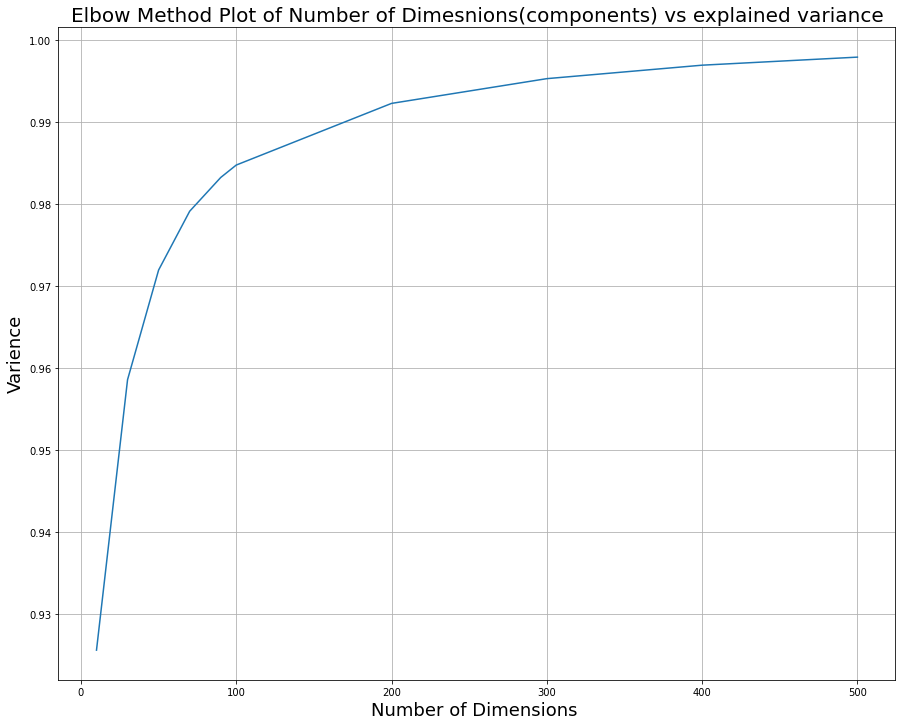

In [0]:
##https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

##https://medium.com/swlh/truncated-singular-value-decomposition-svd-using-amazon-food-reviews-891d97af5d8d

from sklearn.decomposition import TruncatedSVD




# Program to find the optimal number of components for Truncated SVD
diff_dimension = [10,30,50,70,90,100,200,300,400,500]#,3500] # list containing different values of components(dimensions)
variance = [] # explained variance ratio for each component of Truncated SVD
for i in tqdm(diff_dimension):
    svd = TruncatedSVD(n_components=i,n_iter=2)#number of iterations set to 2 for speed up the algorithm 
    svd.fit(cooccurrenceMatrix)
    variance.append(svd.explained_variance_ratio_.sum())
    print("Number of Dimesions(components) = %r and explained variance = %r"%(i,svd.explained_variance_ratio_.sum()))

    

#program to plot the variance vs number of dimensions(elbow method to determine optimal dimensions that will preserve max variance)    
plt.figure(figsize=(15,12))    
plt.plot(diff_dimension, variance)
plt.xlabel('Number of Dimensions ',fontsize=18)
plt.ylabel('Varience',fontsize=18 )
plt.title("Elbow Method Plot of Number of Dimesnions(components) vs explained variance",fontsize=20)
plt.grid()
plt.show()




In [0]:
#### By Observing we can select 200 componets that preserve variance of 0.99  

In [0]:
print("Before Applying SVD::")

print("Shape of co-occurance Matrix cooccurrenceMatrix:",cooccurrenceMatrix.shape)



svd = TruncatedSVD(n_components=200,n_iter=1)
X_co_occurance_matrix_essays_title_svd=svd.fit_transform(cooccurrenceMatrix)


print("="*100)
print("="*100)
print("After Applying SVD::")

print("Shape of Matrix X_co_occurance_matrix_essays_title_svd",X_co_occurance_matrix_essays_title_svd.shape, )
#print("Shape of Matrix X_test_tfidf_svd ",X_test_tfidf_svd.shape," ,Shape of matrix y_test ",y_test.shape)

Before Applying SVD::
Shape of co-occurance Matrix cooccurrenceMatrix: (2000, 2000)
After Applying SVD::
Shape of Matrix X_co_occurance_matrix_essays_title_svd (2000, 200)


## 2.5 Dictionary of words that are present in the Co-occurance Matrix

In [0]:
word_dict_avg_w2v = {}
for i in tqdm(range(len(top_2000_words_essays_title))):
    word_dict_avg_w2v[top_2000_words_essays_title[i]] = X_co_occurance_matrix_essays_title_svd  [i]

100%|██████████| 2000/2000 [00:00<00:00, 614145.11it/s]


In [0]:
len(word_dict_avg_w2v)

2000

In [0]:
#https://www.geeksforgeeks.org/python-get-first-n-keyvalue-pairs-in-given-dictionary/

import itertools 

# Using islice() + items()  
# Get first N items in dictionary  
out = dict(itertools.islice(word_dict_avg_w2v.items(), 1))  
        
# printing result   
print("word_dict_avg_w2v first Key Value Pair = \n" + str(out))  

word_dict_avg_w2v first Key Value Pair = 
{'physics': array([ 1.37809687e+01, -8.66053403e+00,  1.34286247e+00, -2.56647185e+00,
       -3.85346562e-01,  1.96121377e+00, -4.90967227e-01,  3.98108670e-01,
       -1.00320254e+00,  3.72940056e-01, -3.24562491e+00, -9.36961890e-01,
       -9.13448509e-01,  1.99230062e-01, -5.82953161e-01, -1.47440456e+00,
        5.32821859e-03,  4.38483134e-01,  1.56219327e+00, -2.32247046e+00,
        3.39848114e-01, -1.27732104e+00,  3.21766879e-01, -2.79145124e-02,
       -3.78340997e-01,  4.41946508e-01, -1.68783816e+00, -2.96861336e+00,
       -3.02023730e-01,  1.75074108e+00,  5.42565644e-02,  4.49343794e-01,
        1.46933261e+00,  1.34679894e+00,  7.52293536e-02,  1.64903632e-01,
       -1.49221354e-01, -1.08987907e+00,  7.58924583e-01,  9.01465180e-02,
       -4.37441066e-01,  1.53729965e-01,  7.58796976e-01,  4.18509184e-01,
       -8.70749472e-01, -1.02455754e+00, -1.85463425e+00, -4.74125302e-01,
       -5.91697053e-01,  5.52395726e-01,  5.18

In [0]:
glove_words_top_2000_words =  list(word_dict_avg_w2v.keys())#List of keys that are present the word_dict_avg_w2v

In [0]:
#stronging variables into pickle files python: 
#http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

print(len(glove_words_top_2000_words))
print(glove_words_top_2000_words[:10])

2000
['physics', 'calculators', 'dash', 'dot', 'chemistry', 'kitchen', 'makerspace', 'legos', 'fractions', 'lights']


## 2.6 AVG w2v of Prepossed Essays Train & Test from top 2000 words of Co-Occurance Matrix

In [0]:
# average Word2Vec
# compute average word2vec for each review.
X_train_essays_avg_w2v_ = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words_top_2000_words:
            vector += word_dict_avg_w2v[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_essays_avg_w2v_.append(vector)

print(len(X_train_essays_avg_w2v_))
print(len(X_train_essays_avg_w2v_[0]))
#X_train_essays_avg_w2v_

100%|██████████| 20100/20100 [01:13<00:00, 274.51it/s]

20100
200


In [0]:
# average Word2Vec
# compute average word2vec for each review.
X_test_essays_avg_w2v_ = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words_top_2000_words:
            vector += word_dict_avg_w2v[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_essays_avg_w2v_.append(vector)

print(len(X_test_essays_avg_w2v_))
print(len(X_test_essays_avg_w2v_[0]))


100%|██████████| 9900/9900 [00:34<00:00, 286.40it/s]

9900
200


## 2.7   AVG w2v representation of  Preprocessed Project Title into train ,test

In [0]:
# average Word2Vec
# compute average word2vec for each review.
X_train_project_title_avg_w2v_ = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_project_title']): # for each review/sentence
    vector = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words_top_2000_words:
            vector += word_dict_avg_w2v[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_train_project_title_avg_w2v_.append(vector)

print(len(X_train_project_title_avg_w2v_))
print(len(X_train_project_title_avg_w2v_[0]))

100%|██████████| 20100/20100 [00:02<00:00, 7569.95it/s]

20100
200


In [0]:
# average Word2Vec
# compute average word2vec for each review.
X_test_project_title_avg_w2v_ = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_project_title']): # for each review/sentence
    vector = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words_top_2000_words:
            vector += word_dict_avg_w2v[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    X_test_project_title_avg_w2v_.append(vector)

print(len(X_test_project_title_avg_w2v_))
print(len(X_test_project_title_avg_w2v_[0]))

100%|██████████| 9900/9900 [00:01<00:00, 7359.58it/s]

9900
200


we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

## 2.8 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

### 2.8.1 One Hot Encoding Representation of Categories for train test 

In [0]:
##https://www.appliedaicourse.com/course/11/Applied-Machine-learning-course


# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=False, binary=True)

X_train_categories_one_hot = vectorizer.fit_transform(X_train['clean_categories'].values)#fit to only training dataset 
print(vectorizer.get_feature_names())
print("="*100)
print("Shape of matrix X_train_categories_one_hot after one hot encodig ",X_train_categories_one_hot.shape)


X_test_categories_one_hot = vectorizer.transform(X_test['clean_categories'].values)
print("Shape of matrix X_test_categories_one_hot  after one hot encodig ",X_test_categories_one_hot.shape)

['AppliedLearning', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds']
Shape of matrix X_train_categories_one_hot after one hot encodig  (20100, 7)
Shape of matrix X_test_categories_one_hot  after one hot encodig  (9900, 7)


### 2.8.2 One Hot Encoding Representation of Sub-Categories for train, test 

In [0]:
# we use count vectorizer to convert the values into one 
vectorizer = CountVectorizer(lowercase=False, binary=True)

X_train_sub_categories_one_hot = vectorizer.fit_transform(X_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())

print("="*125)
print("Shape of matrix X_train_sub_categories_one_hot after one hot encodig ",X_train_sub_categories_one_hot.shape)

X_test_sub_categories_one_hot = vectorizer.transform(X_test['clean_subcategories'].values)
print("Shape of matrix X_test_sub_categories_one_hot after one hot encodig ",X_test_sub_categories_one_hot.shape)

['AppliedSciences', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts']
Shape of matrix X_train_sub_categories_one_hot after one hot encodig  (20100, 28)
Shape of matrix X_test_sub_categories_one_hot after one hot encodig  (9900, 28)


### 2.8.3 One Hot Encoding Representation of School State for train test

In [0]:
# we use count vectorizer to convert the values into one hot encoded features
#from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=False, binary=True)

X_train_school_state_one_hot=vectorizer.fit_transform(X_train['school_state'].values)
print(vectorizer.get_feature_names())

print("="*125)
print("Shape of matrix X_train_state after one hot encodig ",X_train_school_state_one_hot.shape)


X_test_school_state_one_hot = vectorizer.transform(X_test['school_state'].values)
print("Shape of matrix X_test_school_state_one_hot after one hot encodig ",X_test_school_state_one_hot.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of matrix X_train_state after one hot encodig  (20100, 51)
Shape of matrix X_test_school_state_one_hot after one hot encodig  (9900, 51)


### 2.8.4 One Hot Encoding Representation of Teacher Prefix for train test 

In [0]:
# we use count vectorizer to convert the values into one hot encoded features
#search term "np.nan is an invalid document, expected byte or unicode string."::https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document/39308809
# search tern "np.nan is an invalid document, expected byte or unicode string" ::https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document


vectorizer = CountVectorizer(lowercase=False, binary=True)

X_train_teacher_prefix_one_hot = vectorizer.fit_transform(X_train['teacher_prefix_clean'].values.astype('U'))
print(vectorizer.get_feature_names())
print("="*125)
print("Shape of X_train_teacher_prefix___one_hot matrix after one hot encodig ",X_train_teacher_prefix_one_hot.shape)


X_test_teacher_prefix_one_hot = vectorizer.transform(X_test['teacher_prefix_clean'].values.astype('U'))
print("Shape of X_test_teacher_prefix_one_hot matrix after one hot encodig ",X_test_teacher_prefix_one_hot.shape)

['Dr', 'Mr', 'Mrs', 'Ms', 'Teacher', 'nan']
Shape of X_train_teacher_prefix___one_hot matrix after one hot encodig  (20100, 6)
Shape of X_test_teacher_prefix_one_hot matrix after one hot encodig  (9900, 6)


### 2.8.5  One Hot Encoding Representation of Project Grades for train test

In [0]:
#reference::https://www.appliedaicourse.com/course/applied-ai-course-online
#https://www.kaggle.com/naveennagari/donorschoose-eda-and-tsne/notebook

vectorizer = CountVectorizer(lowercase=False, binary=True)

X_train_project_grade_one_hot = vectorizer.fit_transform(X_train['cleaned_Grades'])
print(vectorizer.get_feature_names())
print("="*125)
print("Shape of X_train_project_grade_one_hot matrix after one hot encodig for school states ",X_train_project_grade_one_hot.shape)



X_test_project_grade_one_hot = vectorizer.transform(X_test['cleaned_Grades'])
print("Shape of X_test_project_grade_one_hot matrix after one hot encodig for school states ",X_test_project_grade_one_hot.shape)

['Grades_3_5', 'Grades_6_8', 'Grades_9_12', 'Grades_PreK_2']
Shape of X_train_project_grade_one_hot matrix after one hot encodig for school states  (20100, 4)
Shape of X_test_project_grade_one_hot matrix after one hot encodig for school states  (9900, 4)


## 2.9 Vectorizing Numerical Feature 

### 2.9.1 Numerical Feature Price Standadize to Train Test

In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(1,-1))
#normalizer.fit(X_cv['price'].values.reshape(1,-1))
#normalizer.fit(X_train['price'].values.reshape(1,-1))

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

X_train_price_norm = normalizer.fit_transform(X_train['price'].values.reshape(1,-1))

X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm=X_train_price_norm.reshape(-1,1)
X_test_price_norm=X_test_price_norm.reshape(-1,1)


print("After vectorizations")
print("="*100)
print("Shape of Matrix X_train_price_norm:",X_train_price_norm.shape,", Shape of Matrix y_train:", y_train.shape)
print("Shape of Matrix X_test_price_norm:",X_test_price_norm.shape, ", Shape of Matrix y_test:",y_test.shape)

After vectorizations
Shape of Matrix X_train_price_norm: (20100, 1) , Shape of Matrix y_train: (20100,)
Shape of Matrix X_test_price_norm: (9900, 1) , Shape of Matrix y_test: (9900,)


### 2.9.2 Numerical Feature teacher_number_of_previously_posted_projects to Train Test 

In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
#normalizer.fit(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
#normalizer.fit(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
#normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_teacher_number_of_previously_posted_projects_norm = normalizer.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_teacher_number_of_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_teacher_number_of_previously_posted_projects_norm=X_train_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)
X_test_teacher_number_of_previously_posted_projects_norm=X_test_teacher_number_of_previously_posted_projects_norm.reshape(-1,1)

print("After vectorizations")
print("="*100)
print("Shape of Matrix X_train_teacher_number_of_previously_posted_projects_norm:",X_train_teacher_number_of_previously_posted_projects_norm.shape,"\nShape of Matrix y_train:", y_train.shape)
print("Shape of Matrix X_test_teacher_number_of_previously_posted_projects_norm:",X_test_teacher_number_of_previously_posted_projects_norm.shape,"\nShape of Matrix y_test:", y_test.shape)
print("="*100)


After vectorizations
Shape of Matrix X_train_teacher_number_of_previously_posted_projects_norm: (20100, 1) 
Shape of Matrix y_train: (20100,)
Shape of Matrix X_test_teacher_number_of_previously_posted_projects_norm: (9900, 1) 
Shape of Matrix y_test: (9900,)


### 2.9.3 Numerical Feature Quantities to Train Test 

In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
#normalizer.fit(X_train['quantity'].values.reshape(1,-1))

X_train_quantity_norm = normalizer.fit_transform(X_train['quantity'].values.reshape(1,-1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(1,-1))


X_train_quantity_norm=X_train_quantity_norm.reshape(-1,1)
X_test_quantity_norm=X_test_quantity_norm.reshape(-1,1)


print("After vectorizations")
print("="*100)
print("Shape of Matrix X_train_quantity_norm:",X_train_quantity_norm.shape,", Shape of Matrix y_train:", y_train.shape)
print("Shape of Matrix X_test_quantity_norm:",X_test_quantity_norm.shape, ", Shape of Matrix y_test:",y_test.shape)
print("="*100)




After vectorizations
Shape of Matrix X_train_quantity_norm: (20100, 1) , Shape of Matrix y_train: (20100,)
Shape of Matrix X_test_quantity_norm: (9900, 1) , Shape of Matrix y_test: (9900,)


### 2.9.4 Normalization of  Feature Sentiment Score to Train Test

In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
#normalizer.fit(X_train['quantity'].values.reshape(1,-1))

X_train_sentiment_score_norm = normalizer.fit_transform(X_train['sentiment_score'].values.reshape(1,-1))
X_test_sentiment_score_norm = normalizer.transform(X_test['sentiment_score'].values.reshape(1,-1))


X_train_sentiment_score_norm=X_train_sentiment_score_norm.reshape(-1,1)
X_test_sentiment_score_norm=X_test_sentiment_score_norm.reshape(-1,1)


print("After vectorizations")
print("="*100)
print("Shape of Matrix X_train_sentiment_score_norm:",X_train_sentiment_score_norm.shape,", Shape of Matrix y_train:", y_train.shape)
print("Shape of Matrix X_test_sentiment_score_norm:",X_test_sentiment_score_norm.shape, ", Shape of Matrix y_test:",y_test.shape)
print("="*100)


After vectorizations
Shape of Matrix X_train_sentiment_score_norm: (20100, 1) , Shape of Matrix y_train: (20100,)
Shape of Matrix X_test_sentiment_score_norm: (9900, 1) , Shape of Matrix y_test: (9900,)


### 2.9.5 Normalization of  Number of words Essays Train Test

In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
#normalizer.fit(X_train['quantity'].values.reshape(1,-1))

X_train_number_words_essays_norm = normalizer.fit_transform(X_train['number_words_essays'].values.reshape(1,-1))
X_test_number_words_essays_norm = normalizer.transform(X_test['number_words_essays'].values.reshape(1,-1))


X_train_number_words_essays_norm=X_train_number_words_essays_norm.reshape(-1,1)
X_test_number_words_essays_norm=X_test_number_words_essays_norm.reshape(-1,1)


print("After vectorizations")
print("="*100)
print("Shape of Matrix X_train_number_words_essays_norm:",X_train_number_words_essays_norm.shape,", Shape of Matrix y_train:", y_train.shape)
print("Shape of Matrix X_test_number_words_essays_norm:",X_test_number_words_essays_norm.shape, ", Shape of Matrix y_test:",y_test.shape)
print("="*100)


After vectorizations
Shape of Matrix X_train_number_words_essays_norm: (20100, 1) , Shape of Matrix y_train: (20100,)
Shape of Matrix X_test_number_words_essays_norm: (9900, 1) , Shape of Matrix y_test: (9900,)


### 2.9.6 Normalization of  Number of words Project Title Train ,Test

In [0]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
#normalizer.fit(X_train['quantity'].values.reshape(1,-1))

X_train_number_words_project_title_norm = normalizer.fit_transform(X_train['number_words_project_title'].values.reshape(1,-1))
X_test_number_words_project_title_norm = normalizer.transform(X_test['number_words_project_title'].values.reshape(1,-1))


X_train_number_words_project_title_norm=X_train_number_words_project_title_norm.reshape(-1,1)
X_test_number_words_project_title_norm=X_test_number_words_project_title_norm.reshape(-1,1)


print("After vectorizations")
print("="*100)
print("Shape of Matrix X_train_number_words_project_title_norm:",X_train_number_words_project_title_norm.shape,", Shape of Matrix y_train:", y_train.shape)
print("Shape of Matrix X_test_number_words_project_title_norm:",X_test_number_words_project_title_norm.shape, ", Shape of Matrix y_test:",y_test.shape)
print("="*100)


After vectorizations
Shape of Matrix X_train_number_words_project_title_norm: (20100, 1) , Shape of Matrix y_train: (20100,)
Shape of Matrix X_test_number_words_project_title_norm: (9900, 1) , Shape of Matrix y_test: (9900,)


## 3 Applying XGBoost on avg_w2v,<font color='red'> SET 1</font>

### 3.1 Merging all the above features for avg_w2v

In [0]:
from scipy.sparse import hstack


X_tr_avg_w2v=hstack((X_train_essays_avg_w2v_,X_train_project_title_avg_w2v_,X_train_categories_one_hot,X_train_sub_categories_one_hot,
                X_train_project_grade_one_hot,X_train_school_state_one_hot,
                 X_train_teacher_prefix_one_hot,X_train_price_norm,X_train_teacher_number_of_previously_posted_projects_norm,X_train_quantity_norm,
                 X_train_number_words_essays_norm,X_train_number_words_project_title_norm,X_train_sentiment_score_norm)).tocsr()


X_test_avg_w2v=hstack((X_test_essays_avg_w2v_,X_test_project_title_avg_w2v_,X_test_categories_one_hot,X_test_sub_categories_one_hot,
                X_test_project_grade_one_hot,X_test_school_state_one_hot,
                 X_test_teacher_prefix_one_hot,X_test_price_norm,X_test_teacher_number_of_previously_posted_projects_norm,X_test_quantity_norm,
                 X_test_number_words_essays_norm,X_test_number_words_project_title_norm,X_test_sentiment_score_norm)).tocsr()


print("Final Data matrix")
print("X_tr_avg_w2v shape:",X_tr_avg_w2v.shape,", y_train:", y_train.shape)
print("X_test_avg_w2v shape:",X_test_avg_w2v.shape,", y_test:", y_test.shape)
print("="*100)

Final Data matrix
X_tr_avg_w2v shape: (20100, 502) , y_train: (20100,)
X_test_avg_w2v shape: (9900, 502) , y_test: (9900,)


## 3.2 Hyperparameter Tuning n_estimators & max_depth of XGBoost

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time

GBDT = xgb.XGBClassifier(n_jobs=-1,class_weight='balanced')
parameters = {'n_estimators': [1,2,3,4,5], 'max_depth':[2,3,4,5,6 ]}
clf = RandomizedSearchCV(GBDT, parameters, cv= 2, scoring='roc_auc',return_train_score=True,n_jobs=-1,verbose=20)
clf.fit(X_tr_avg_w2v, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
#results = results.sort_values(['param_n_neighbors'])

#https://stackoverflow.com/questions/57136676/sklearn-model-selection-gridsearchcv-is-throwing-keyerror-mean-train-score

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std=results['std_test_score']
n_estimators= results['param_n_estimators']
max_depth= results['param_max_depth']

best_n_estimators=clf.best_params_
print("="*100)
Best_hyperparameter_GBDT_n_estimators_avg_w2v=best_n_estimators.get("n_estimators")
print("Best_hyperparameter_GBDT_n_estimators_avg_w2v:",Best_hyperparameter_GBDT_n_estimators_avg_w2v)
print("="*100)
#results.head(2)


best_max_depth=clf.best_params_
print("="*100)
Best_hyperparameter_GBDT_max_depth_avg_w2v=best_max_depth.get("max_depth")
print("Best_hyperparameter_GBDT_max_depth_avg_w2v:",Best_hyperparameter_GBDT_max_depth_avg_w2v)
print("="*100)
#results.head(2)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

Best_hyperparameter_GBDT_n_estimators_avg_w2v: 5
Best_hyperparameter_GBDT_max_depth_avg_w2v: 4


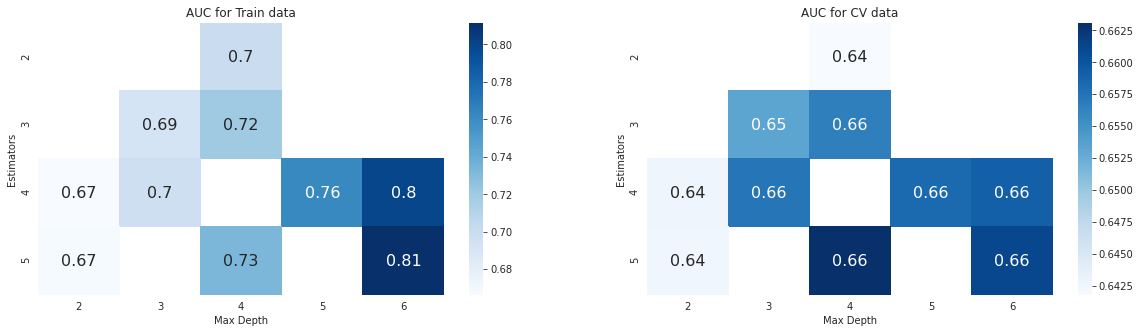

In [0]:
#https://www.kaggle.com/arindambanerjee/grid-search-simplified
max_depth_list = list(clf.cv_results_['param_max_depth'].data)
estimators_list = list(clf.cv_results_['param_n_estimators'].data)

sns.set_style("whitegrid")
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
data = pd.DataFrame(data={'Estimators':estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_train_score']})
data = data.pivot(index='Estimators', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="Blues",annot_kws={"size": 16}).set_title('AUC for Train data')

plt.subplot(1,2,2)
data = pd.DataFrame(data={'Estimators':estimators_list, 'Max Depth':max_depth_list, 'AUC':clf.cv_results_['mean_test_score']})
data = data.pivot(index='Estimators', columns='Max Depth', values='AUC')
sns.heatmap(data, annot=True, cmap="Blues",annot_kws={"size": 16}).set_title('AUC for CV data')
plt.show()

## 3.3 ROC Curve on XGBoost with Best Hyperparameter 

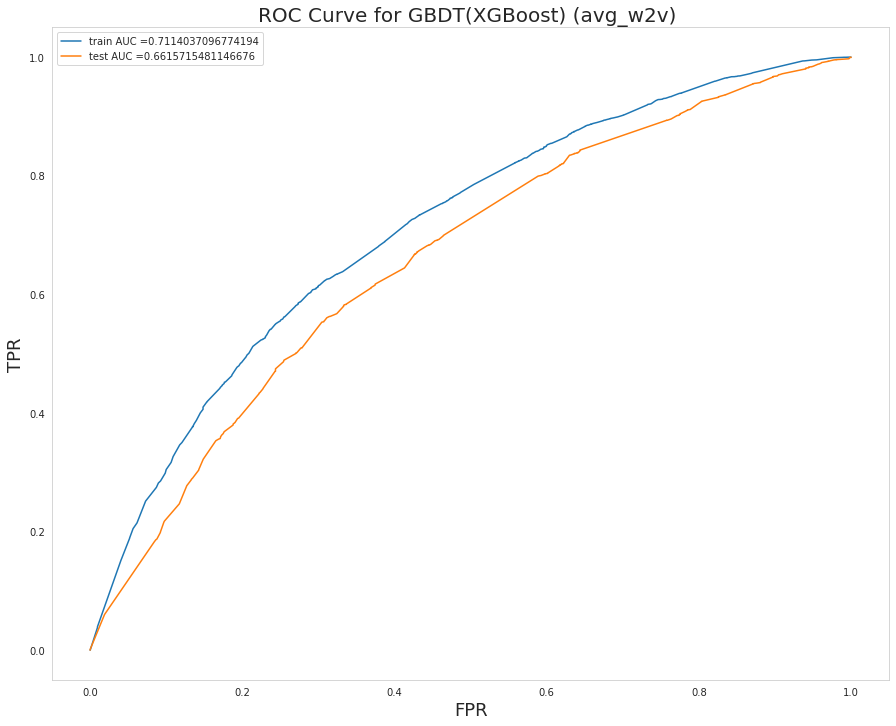

In [0]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


GBDT = xgb.XGBClassifier(n_estimators=Best_hyperparameter_GBDT_n_estimators_avg_w2v,
                         max_depth=Best_hyperparameter_GBDT_max_depth_avg_w2v,
                         n_jobs=-1,
                         class_weight='balanced',)

GBDT.fit(X_tr_avg_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = GBDT.predict_proba(X_tr_avg_w2v)
train_preds = y_train_pred[:,1]  ##https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
y_test_pred = GBDT.predict_proba(X_test_avg_w2v)
test_preds=y_test_pred[:,1] ##https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, train_preds)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, test_preds)

plt.figure(figsize=(15,12))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR",fontsize=18)
plt.ylabel("TPR",fontsize=18)
plt.title("ROC Curve for GBDT(XGBoost) (avg_w2v) ",fontsize=20)
plt.grid()
plt.show()

test_AUC_avg_w2v=""+str(auc(test_fpr, test_tpr))

In [0]:
test_AUC_avg_w2v=""+str(auc(test_fpr, test_tpr))
test_AUC_avg_w2v=float(test_AUC_avg_w2v)
test_AUC_avg_w2v="%.2f" % round(test_AUC_avg_w2v,2)
print("="*50)
print("="*50)
print("Test AUC score on XGBoost=",test_AUC_avg_w2v)
print("="*50)
print("="*50)

Test AUC score on XGBoost= 0.66


## 3.3 Confusion Matrix of XGBoost 

In [0]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



In [0]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("="*100)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(train_preds, best_t)))

print("="*100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(test_preds, best_t)))

the maximum value of tpr*(1-fpr) 0.4310910056925996 for threshold 0.638
Train confusion matrix
[[ 2136   964]
 [ 6364 10636]]
Test confusion matrix
[[ 850  677]
 [2661 5712]]


Text(0.5, 1.0, 'XGBoost Test Confusion Matrix')

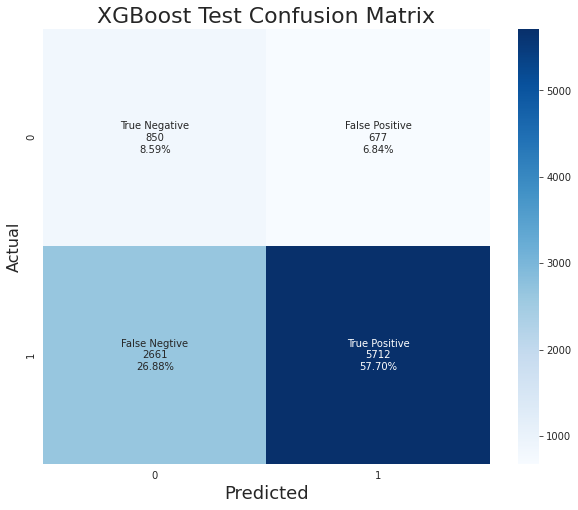

In [0]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

cf_matrix_test =confusion_matrix(y_test, predict_with_best_t(test_preds, best_t))


plt.figure(figsize=(10,8))
group_names = ['True Negative','False Positive','False Negtive','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_test.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_test.flatten()/np.sum(cf_matrix_test)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_test, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=16)
plt.title('XGBoost Test Confusion Matrix',fontsize=22)


#sns.heatmap(cf_matrix, annot=True)

#confusion_matrix(y_test,y_data_pred)